In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from protosc.parallel import execute_parallel

from nudging.model import BiRegressor, MonoRegressor, XRegressor
from nudging.cate import get_cate_correlations, get_cate_top_performance
from nudging.simulation import generate_multi_dataset

In [2]:
np.random.seed(12390845)
datasets = generate_multi_dataset(300, linear=False)

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, SGDRegressor, ElasticNet
from sklearn.linear_model import ARDRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
regressors = {
    "gauss_process": GaussianProcessRegressor,
    "ridge": Ridge,
    "linear": LinearRegression,
    "sgd": SGDRegressor,
    "elasticnet": ElasticNet,
    "ard": ARDRegression,
    "bayesian_ridge": BayesianRidge,
    "knn": KNeighborsRegressor,
    "mlp": MLPRegressor,
    "svm": SVR,
    "decision_tree": DecisionTreeRegressor,
    "extra_tree": ExtraTreeRegressor,
}
    

In [4]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


In [5]:
def plot_cate(data, model):
    X, truth = data
    cate_estimate = get_cate(X, model)
    plt.scatter(truth["cate"], cate_estimate)
    plt.show()
    print(stats.pearsonr(truth["cate"], cate_estimate))

In [6]:
def compute_performance(model, data):
    return get_cate_top_performance(model, data)


In [7]:
@ignore_warnings(category=ConvergenceWarning)
def compute_learners(i_data, name):
    regressor = regressors[name]
    cur_data = datasets[i_data]
    slearn_result = get_cate_top_performance(MonoRegressor(regressor()), cur_data)
    tlearn_result = get_cate_top_performance(BiRegressor(regressor()), cur_data)
    xlearn_result = get_cate_top_performance(XRegressor(regressor()), cur_data)
    return name, slearn_result, tlearn_result, xlearn_result

In [8]:
jobs = []
for name in regressors:
    jobs.extend([{"i_data": i_data, "name": name} for i_data in range(len(datasets))])

In [9]:
results = execute_parallel(jobs, compute_learners, progress_bar=True, n_jobs=10)

100%|██████████| 3600/3600 [1:16:13<00:00,  1.27s/it]  


In [25]:
def get_rank(value, i_data):
    all_values = []
    for res in results[i_data::len(datasets)]:
        all_values.extend(res[1:])
    return np.mean(np.where(-np.sort(-np.array(all_values)) == value)[0])

def plot_results(name):
    sub_res = [x for x in results if x[0] == name]
    labels = ["s-learner", "t-learner", "x-learner"]
    for i in range(1, 4):
        r = [x[i] for x in sub_res]
        plt.scatter(np.arange(len(r)), np.sort(r), label=labels[i-1])
    plt.title(name)
    plt.legend()
    plt.show()
    
def compute_avg_rank(name):
    ranks = np.zeros(3)
    sub_res = [x for x in results if x[0] == name]
    labels = ["s-learner", "t-learner", "x-learner"]
    for i in range(1, 4):
        for i_data in range(len(datasets)):
            perf = sub_res[i_data][i]
            ranks[i-1] += get_rank(perf, i_data)
    return ranks/len(datasets)

def compute_avg_results(name):
    performance = np.zeros(3)
    sub_res = [x for x in results if x[0] == name]
    labels = ["s-learner", "t-learner", "x-learner"]
    for i in range(1, 4):
        for i_data in range(len(datasets)):
            performance[i-1] += sub_res[i_data][i]
    return performance/len(datasets)



In [23]:
rank_res = []
perf_res = []
labels = ["s-learner", "t-learner", "x-learner"]

for name in regressors:
    avg_rank = compute_avg_rank(name)
    avg_perf = compute_avg_results(name)
    rank_res.extend([(name+f" ({labels[i]})", avg_rank[i], avg_perf[i]) for i in range(len(avg_rank))])
sorted(rank_res, key=lambda x: x[1])

[('ard (x-learner)', 7.583333333333333, 0.7579245651047276),
 ('mlp (x-learner)', 7.873333333333333, 0.7565567581194566),
 ('linear (x-learner)', 7.986666666666666, 0.7547930567036558),
 ('ridge (t-learner)', 8.25, 0.7543632849612968),
 ('ard (t-learner)', 8.386666666666667, 0.7539956992699441),
 ('bayesian_ridge (t-learner)', 8.446666666666667, 0.7510552088371483),
 ('linear (t-learner)', 8.476666666666667, 0.7532338417970443),
 ('ridge (x-learner)', 8.526666666666667, 0.7536288880186962),
 ('mlp (t-learner)', 8.55, 0.7518280601729184),
 ('bayesian_ridge (x-learner)', 8.753333333333334, 0.7493385085728044),
 ('svm (t-learner)', 13.016666666666667, 0.7149907966174174),
 ('svm (x-learner)', 13.873333333333333, 0.7089268033979369),
 ('mlp (s-learner)', 14.666666666666666, 0.7021349222206396),
 ('knn (x-learner)', 15.526666666666667, 0.6787051529599295),
 ('decision_tree (x-learner)', 16.336666666666666, 0.6712123164807955),
 ('knn (s-learner)', 16.366666666666667, 0.6718942551214352),
 (

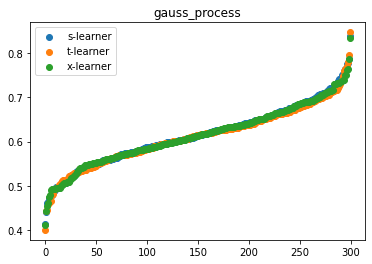

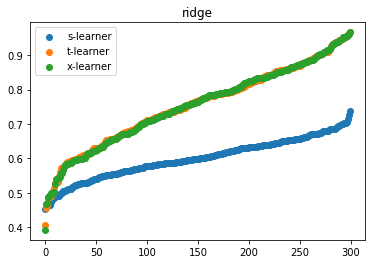

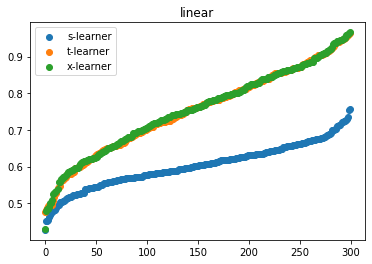

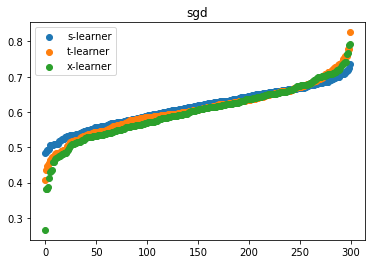

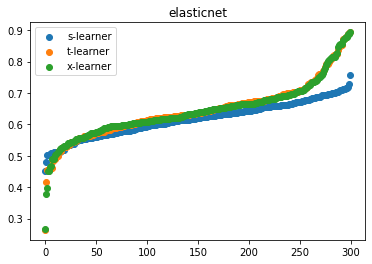

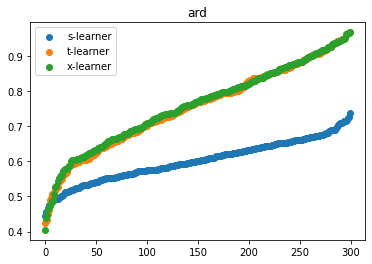

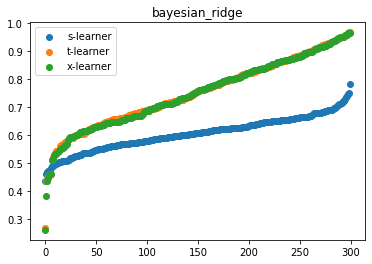

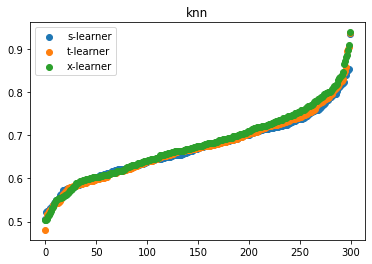

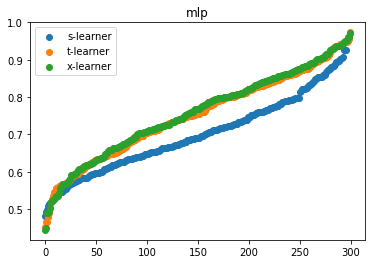

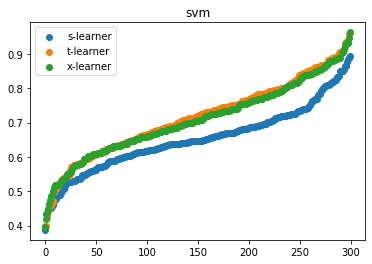

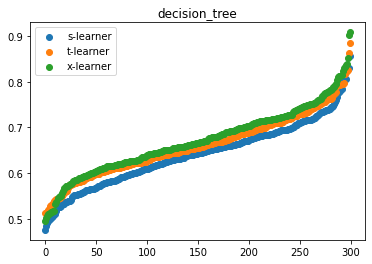

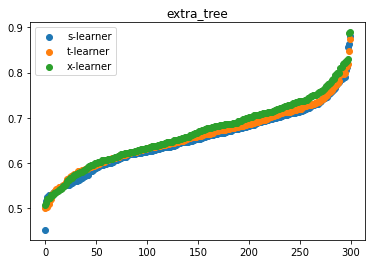

In [26]:
for name in regressors:
    plot_results(name)